<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

2    3638
0    3112
5    2756
4    1354
6    1028
1     742
3     671
Name: state, dtype: int64

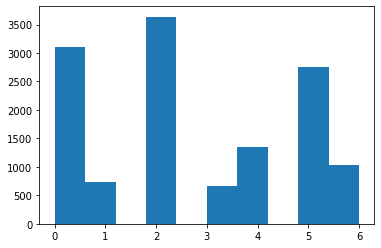

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

0

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 10, 6),
 datetime.date(2022, 9, 24),
 datetime.date(2012, 9, 26),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 10, 6), datetime.date(2022, 9, 24))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/(n - 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_56707/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_56707/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_56707/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_56707/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
A,1.000265,0.998011,1.000226,1.000362,1.001467,1.002032,1.001887,1.014624
AA,1.000252,0.997046,1.000958,1.001402,1.000171,1.001791,1.001065,1.000926
AAIC,0.999488,0.997311,1.000609,1.000120,1.001806,1.001339,1.000100,1.016290
AAL,0.999907,0.995552,1.000350,1.002348,1.001704,0.999804,1.002198,1.015799
AAME,0.999984,0.997446,1.002272,1.000758,1.000882,1.001378,1.000226,1.001414


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6
ZTEK,1.000581,0.999265,0.993827,0.998706,1.007484,1.004594,0.997968,1.047903
ZTR,1.000194,0.999105,1.000653,1.000365,1.000740,1.000704,1.000657,1.001231
ZUMZ,1.000129,0.996943,1.000247,1.001374,1.000945,1.002116,1.001356,1.002545
ZWS,1.000083,0.996505,1.000375,0.999506,0.999931,1.001344,1.001842,1.018651
ZYXI,1.000402,0.999244,1.001502,1.000506,1.000986,0.998079,1.001965,1.030499


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
CURRENT_STATE# = 0

0

In [74]:
exclude = {
    0: ['ADC', 'BCTF', 'CALM', 'CTGO', 'CTSH', 'DG', 'DGX', 'DIT',
        'DTST', 'EBMT', 'ELC', 'ENB', 'ENPH', 'ESOA', 'EW', 'FFDF',
        'FRBA', 'FSI', 'KDP','LFMD', 'MOBQ', 'NEN', 'NLP', 'O', 'OMQS',
        'ORLY', 'POOL', 'RGCO', 'RMD', 'SO', 'TJX', 'UTMD', 'WTRG',
        'YORW'],
    1: []}

In [75]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]

df['weighted'] = {
    0: (0.6*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.3*df.dar)
}[CURRENT_STATE]

df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
ELC,1.001282,1.004077,1.001184,0.997213,1.000159,1.001607,1.001534,0.983368,1.002949
SOBR,0.999815,1.004278,1.001291,0.996616,1.000747,0.996735,0.997005,1.096325,1.002640
FSI,1.001185,1.001737,1.000589,1.000419,1.001394,1.000557,1.000944,1.031835,1.001456
MOBQ,0.999916,1.002479,0.999111,0.995197,1.002800,0.998434,0.998857,1.006362,1.001373
GCBC,1.000694,1.001100,1.001501,1.000049,0.999655,1.000643,1.000610,0.993757,1.001018


In [76]:
df.mean(), df.median()

(dar         1.000160
 dar_0       0.998022
 dar_1       1.000690
 dar_2       1.000601
 dar_3       1.001271
 dar_4       1.001199
 dar_5       1.000964
 dar_6       1.008937
 weighted    0.998929
 dtype: float64,
 dar         1.000246
 dar_0       0.998227
 dar_1       1.000778
 dar_2       1.000650
 dar_3       1.001271
 dar_4       1.001210
 dar_5       1.000945
 dar_6       1.007311
 weighted    0.999089
 dtype: float64)

In [77]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]
#sorted(best_weighted)

In [78]:
print(sorted(best_weighted))

['ABST', 'APT', 'BKT', 'CEF', 'CFFN', 'CZFS', 'FCAP', 'FCN', 'FNV', 'GCBC', 'HMY', 'IEI', 'MICS', 'MIY', 'MUJ', 'NAZ', 'NLY', 'NPV', 'NXP', 'SOBR']


In [79]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,weighted
SOBR,0.999815,1.004278,1.001291,0.996616,1.000747,0.996735,0.997005,1.096325,1.002640
GCBC,1.000694,1.001100,1.001501,1.000049,0.999655,1.000643,1.000610,0.993757,1.001018
MICS,0.999241,1.001591,1.002378,0.997085,0.997875,0.997342,0.997088,1.013261,1.000965
ABST,1.000484,1.000784,1.000549,0.999998,1.001164,0.999993,1.000323,1.002695,1.000671
APT,1.000268,1.000950,0.999260,0.998891,0.998438,0.999434,1.001410,1.016480,1.000576
FCN,1.000549,1.000393,1.000785,0.998199,1.001989,1.000922,1.000911,1.017905,1.000479
FNV,1.000593,1.000257,1.000957,1.001560,0.999945,1.001221,1.000337,1.003625,1.000428
CZFS,1.000352,1.000317,1.000344,1.000660,0.999830,1.000627,1.000217,1.003735,1.000330
FCAP,1.000313,1.000307,0.999577,1.000130,1.000299,1.000510,1.000653,0.996026,1.000236
NLY,1.000307,1.000076,1.000905,0.999750,1.000673,1.000728,1.000232,1.009471,1.000228


In [80]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [81]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,ABST,APT,BKT,CEF,CFFN,CZFS,FCAP,FCN,FNV,GCBC,HMY,IEI,MICS,MIY,MUJ,NAZ,NLY,NPV,NXP,SOBR
Date,,,,,,,,,,,,,,,,,,,,
2022-09-19,10.95,4.02,4.25,15.74,9.07,70.000000,27.420000,157.110001,120.629997,59.139999,2.17,116.059998,5.83,12.86,12.53,13.20,6.17,13.13,13.46,0.91
2022-09-20,10.86,4.01,4.24,15.60,9.13,70.900002,27.500000,157.009995,118.720001,60.360001,2.12,115.730003,5.87,12.73,12.28,13.10,6.08,13.14,13.49,3.03
2022-09-21,10.96,3.99,4.27,15.75,9.06,70.000000,27.049999,157.160004,118.820000,60.680000,2.13,115.790001,5.71,12.76,12.31,13.12,6.01,12.99,13.53,2.39
2022-09-22,10.86,3.98,4.16,15.81,8.98,73.000000,26.799999,157.339996,118.209999,60.330002,2.13,114.849998,5.87,12.64,12.12,13.00,5.87,12.80,13.50,1.73
2022-09-23,10.69,3.99,4.13,15.49,8.88,70.570000,27.080000,159.580002,114.129997,59.849998,2.00,114.660004,5.28,12.51,12.03,12.59,5.65,12.56,13.49,1.55


In [82]:
data = pd.concat([data, states], axis=1)

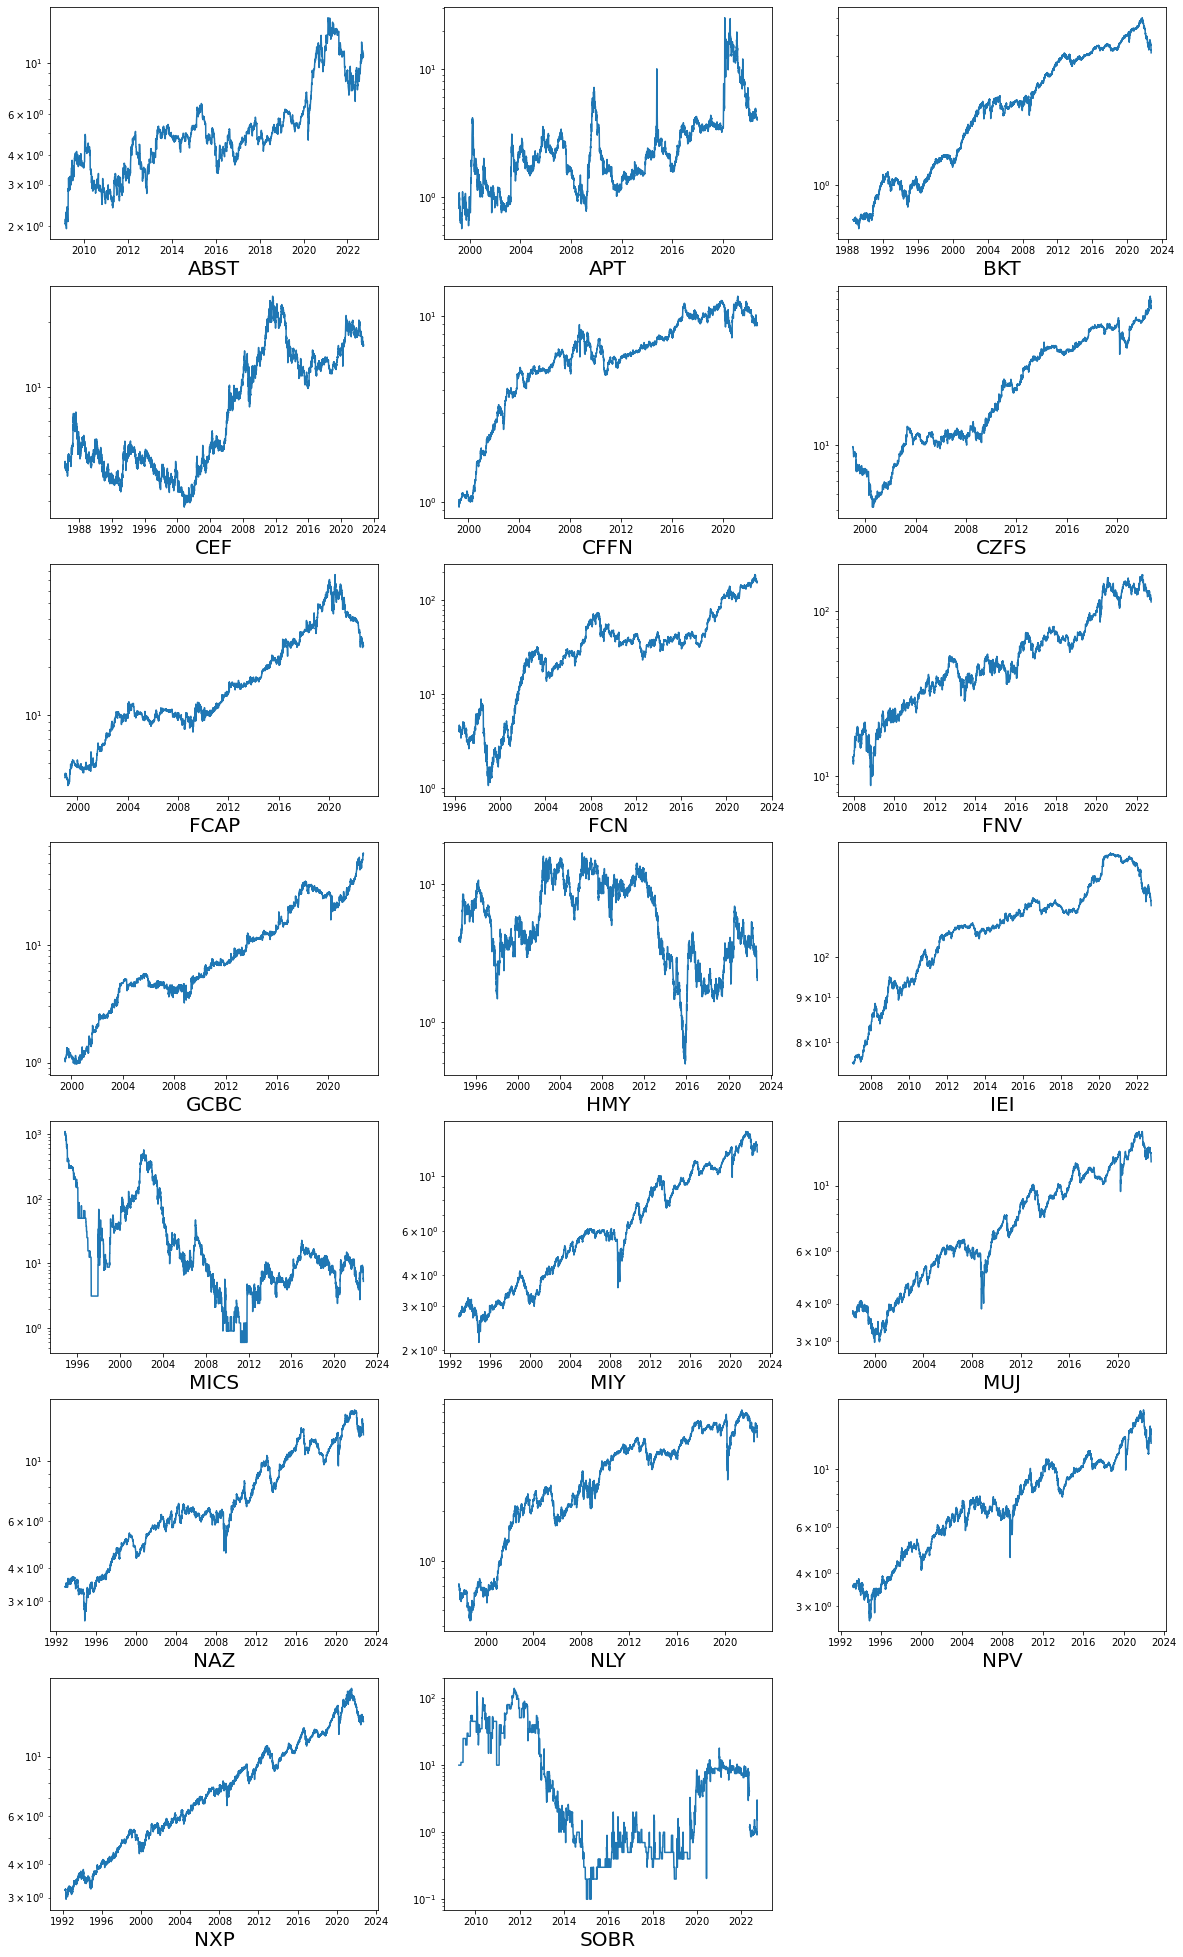

In [83]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

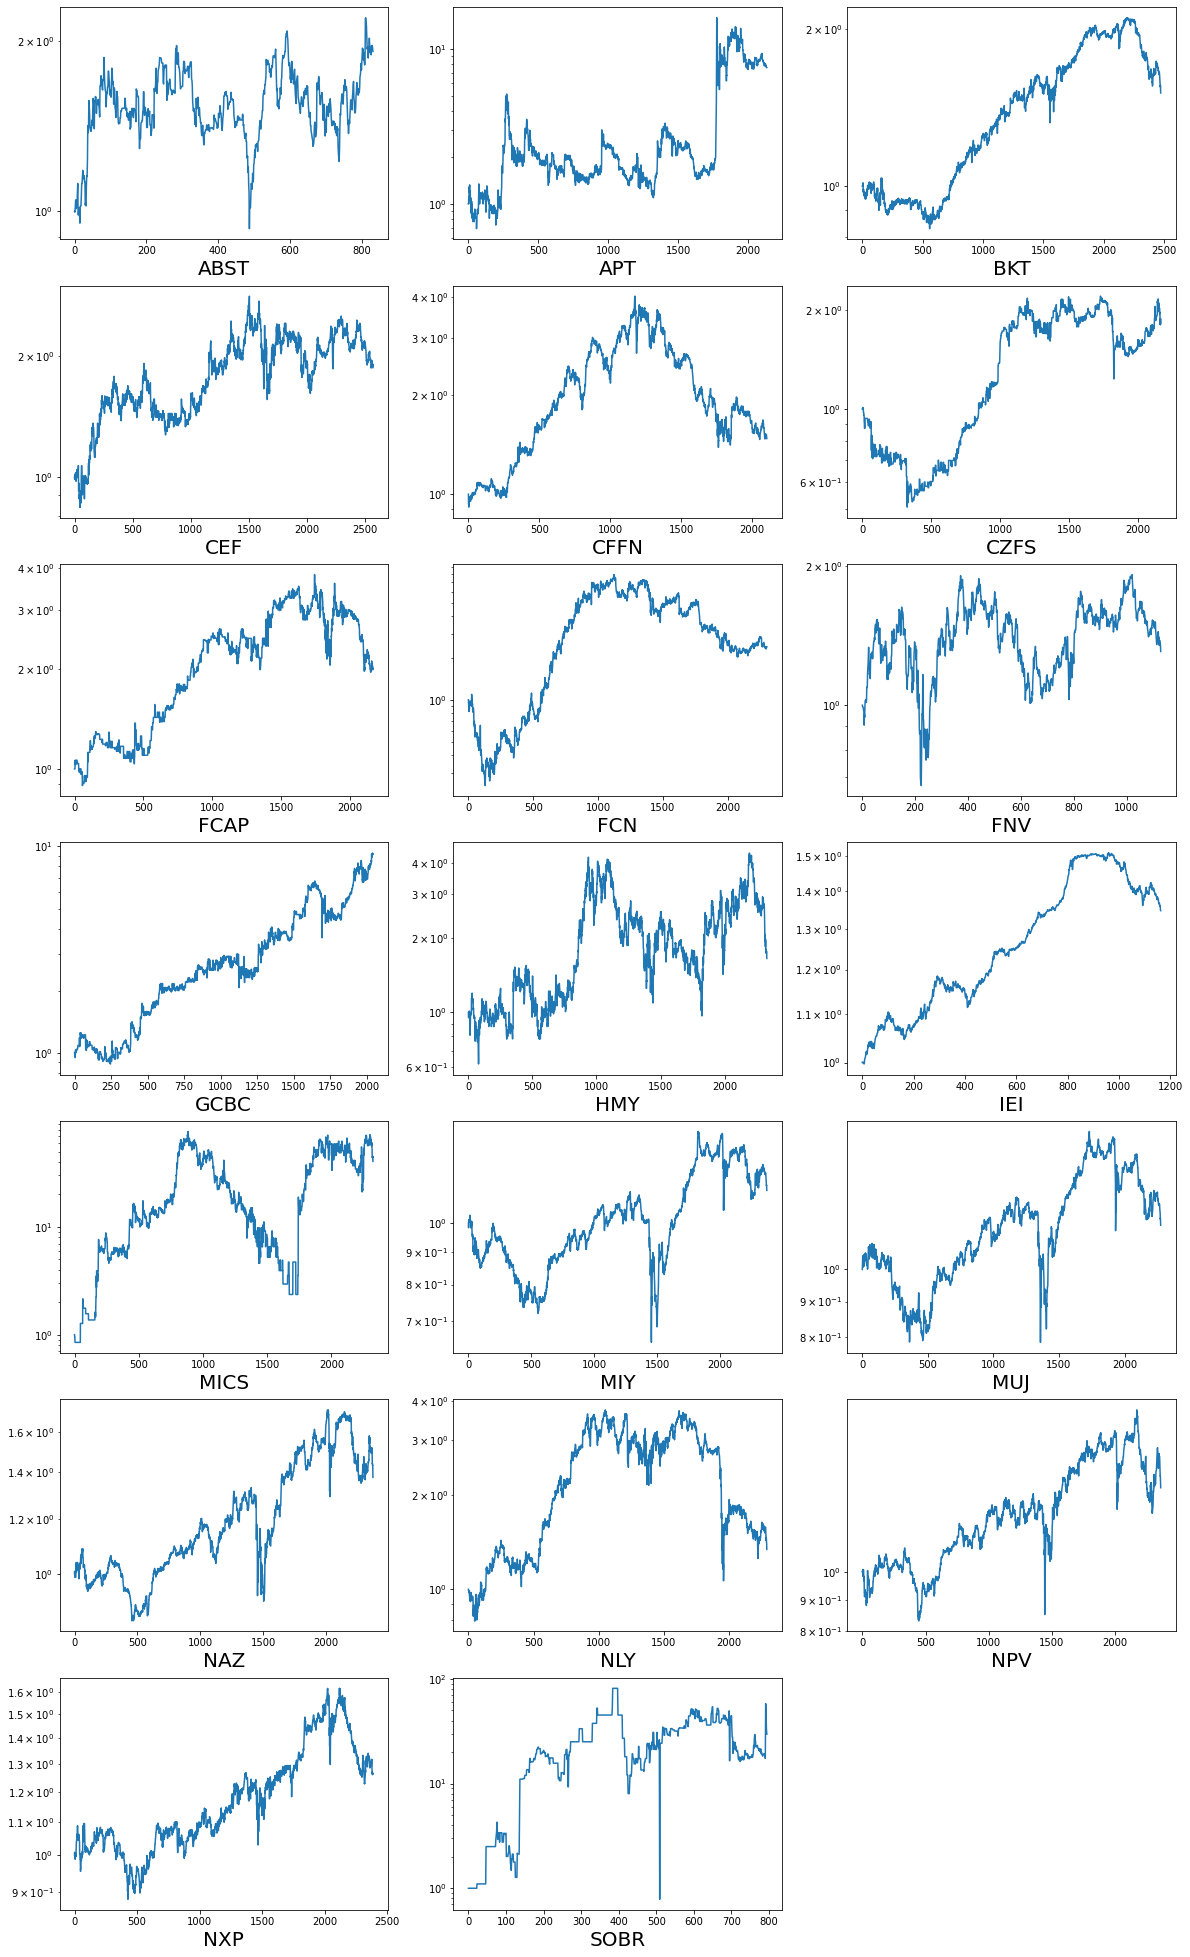

In [84]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);

In [215]:
# Hedged best

hedged = (
    #df[['sharpe_3', 'sharpe_4', 'sharpe_5']]
    df[['sharpe_0', 'sharpe_1', 'sharpe_2']]
    .min(axis=1)
    .sort_values(ascending=False))
df.loc[hedged.index, :]

KeyError: "None of [Index(['sharpe_0', 'sharpe_1', 'sharpe_2'], dtype='object')] are in the [columns]"

In [40]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()

In [41]:
best_0 = best_n_by_state(df, 12, 0)
best_1 = best_n_by_state(df, 20, 1)
best_2 = best_n_by_state(df, 10, 2)
best_3 = best_n_by_state(df, 10, 3)

In [42]:
best_1 = [s for s in best_1 if s not in exclude]
df.loc[best_1, ['sharpe', 'sharpe_0', 'sharpe_1']]

,sharpe,sharpe_0,sharpe_1
SIX,0.454693,-0.340400,3.334819
GOOG,0.820485,-0.950836,3.087762
NOW,0.890719,-1.119144,3.057726
BWXT,0.515901,-1.038705,2.968421
VC,0.476228,-0.720481,2.934320
STK,0.601196,-1.271463,2.895330
GMED,0.615996,-1.013259,2.872070
PODD,0.606082,-0.413301,2.858763
AWK,0.810364,0.049615,2.857471
CRM,0.670351,-0.745700,2.822239
